## Machine learning model-based forecasting of water levels in Venezia, Italia 

_"Acqua alta"_ (Italian for "high water") denotes the tide peaks that periodically flood the city of Venezia, Italia. This phenomenon is primarily caused by a combination of astronomical tides, meteorological factors, and the geographical setting of the Venetian Lagoon. 

The term "acqua alta" is used when the tide exceeds 90 cm (see [Figure 1](venezia_high_waters/acqua_alta_img.png)) above the standard sea level.

The gravitational pull of the moon and the sun causes regular tidal fluctuations. Strong winds, particularly the Sirocco wind [2](https://www.nesdis.noaa.gov/news/rising-sea-levels-and-sirocco-winds-worsen-flooding-venice) from the southeast, can push seawater into the lagoon. Low atmospheric pressure can also contribute to higher sea levels [3](https://veneziaautentica.com/acqua-alta-venice/). 
La Città di Venezia is built on a series of islands in a shallow lagoon, making it particularly susceptible to flooding [4](https://earth.esa.int/web/earth-watching/image-of-the-week/content/-/article/venice-italy-sentinel/). 
Acqua alta has been a part of Venetian life for centuries, but the frequency and severity of these events have increased in recent decades  [5](https://www.euronews.com/green/2024/06/19/new-study-by-italian-scientists-predicts-venice-will-be-underwater-by-2150) .   The most devastating flood in recent history occurred on November 4, 1966, when water levels reached 194 cm above the standard sea level, causing extensive damage to the city [6](https://imagesofvenice.com/the-great-venetian-flood-of-1966/) . 

To combat the increasing threat of acqua alta, the Italian government initiated the MOSE (Modulo Sperimentale Elettromeccanico) project in the early 2000s [7](https://www.mosevenezia.eu/project/?lang=en). This system comprises a series of mobile barriers installed at the three inlets of the Venetian Lagoon (Lido, Malamocco, and Chioggia). These barriers can be raised to block incoming tides and protect the city from flooding. The MOSE project became operational in October 2020 and has since been used to prevent several high tide events from flooding the city.


Venezia is also investing in infrastructure improvements, such as raising the pavement levels in frequently flooded areas and enhancing the drainage system to cope with high water events [8](https://www.themayor.eu/en/a/view/part-of-venice-sewers-will-get-a-long-awaited-restoration-6984). 




<a id="fig1"></a>![Figure 1](acqua_alta_img.png)

**Figure 1.** Visual representation of acqua alta. Image sourced from [[1](https://vincivilworld.com/2022/10/17/components-of-dam-functions/)]

The goal of this notebook is to construct a machine learning model that will forecast the water level in Venezia using its lagged values as well as the hour of the day of the level recording. Throughout the notebook, I will use Polars in lieu of Pandas.

The dataset was sourced from [[9](https://github.com/lbcommer/venezia-high-waters),[10](https://www.kaggle.com/datasets/lbronchal/venezia)]. I loaded the dataset first, taking note of the data types of the columns.

In [2]:
import polars as pl

# Load the CSV file with specific data types
df = pl.read_csv(
    "venezia.csv",
    dtypes={
        "datetime": pl.Datetime,
        "level": pl.Float64
    }
)

df.head()

datetime,level
datetime[μs],f64
1983-01-01 01:00:00,44.0
1983-01-01 02:00:00,35.0
1983-01-01 03:00:00,23.0
1983-01-01 04:00:00,10.0
1983-01-01 05:00:00,1.0


In [3]:
df.shape

(289272, 2)

In [4]:
# Find the minimum and maximum datetime in the DataFrame
min_max_datetime = df.select([
    pl.col("datetime").min().alias("min_datetime"),
    pl.col("datetime").max().alias("max_datetime")
])

print(min_max_datetime)

shape: (1, 2)
┌─────────────────────┬─────────────────────┐
│ min_datetime        ┆ max_datetime        │
│ ---                 ┆ ---                 │
│ datetime[μs]        ┆ datetime[μs]        │
╞═════════════════════╪═════════════════════╡
│ 1983-01-01 01:00:00 ┆ 2016-01-01 00:00:00 │
└─────────────────────┴─────────────────────┘


The dataset **df** comprises ~290000 rows and 2 columns: `datetime` (date and time when the water level is recorded at UTC) and `level` (the water level in cm). The time period ranged from Jan 1, 1983 to Jan 1, 2016. 

I will now check **df** for missing entries and duplicates.

In [5]:
# Create a DataFrame with column names and their data types
df_info = pl.DataFrame({
    'Column': df.columns,
    'Dtype': [str(dtype) for dtype in df.dtypes]
})

# Calculate the number of unique values for each column
unique_counts = df.select([pl.col(col).n_unique().alias(col) for col in df.columns])
df_info = df_info.with_columns([
    pl.Series('Unique', unique_counts.row(0))
])

# Calculate the number of null values for each column
null_counts = df.select([pl.col(col).is_null().sum().alias(col) for col in df.columns])
df_info = df_info.with_columns([
    pl.Series('Null', null_counts.row(0))
])

df_info

Column,Dtype,Unique,Null
str,str,i64,i64
"""datetime""","""Datetime(time_unit='us', time_…",289267,0
"""level""","""Float64""",240,0


In [85]:
duplicate_count = df.is_duplicated().sum()
duplicate_count

0

In [ ]:
`scikit-learn` will be used to standardize the `level` column and name the transformed version `level_standardized`.

In [7]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the 'level' column
df = df.with_columns([
    pl.Series('level_standardized', scaler.fit_transform(df['level'].to_numpy().reshape(-1, 1)).flatten())
])

df.head()

datetime,level,level_standardized
datetime[μs],f64,f64
1983-01-01 01:00:00,44.0,0.621919
1983-01-01 02:00:00,35.0,0.31296
1983-01-01 03:00:00,23.0,-0.098985
1983-01-01 04:00:00,10.0,-0.545259
1983-01-01 05:00:00,1.0,-0.854218


Seasonalities will be checked using `scipy.signal`'s periodogram. 

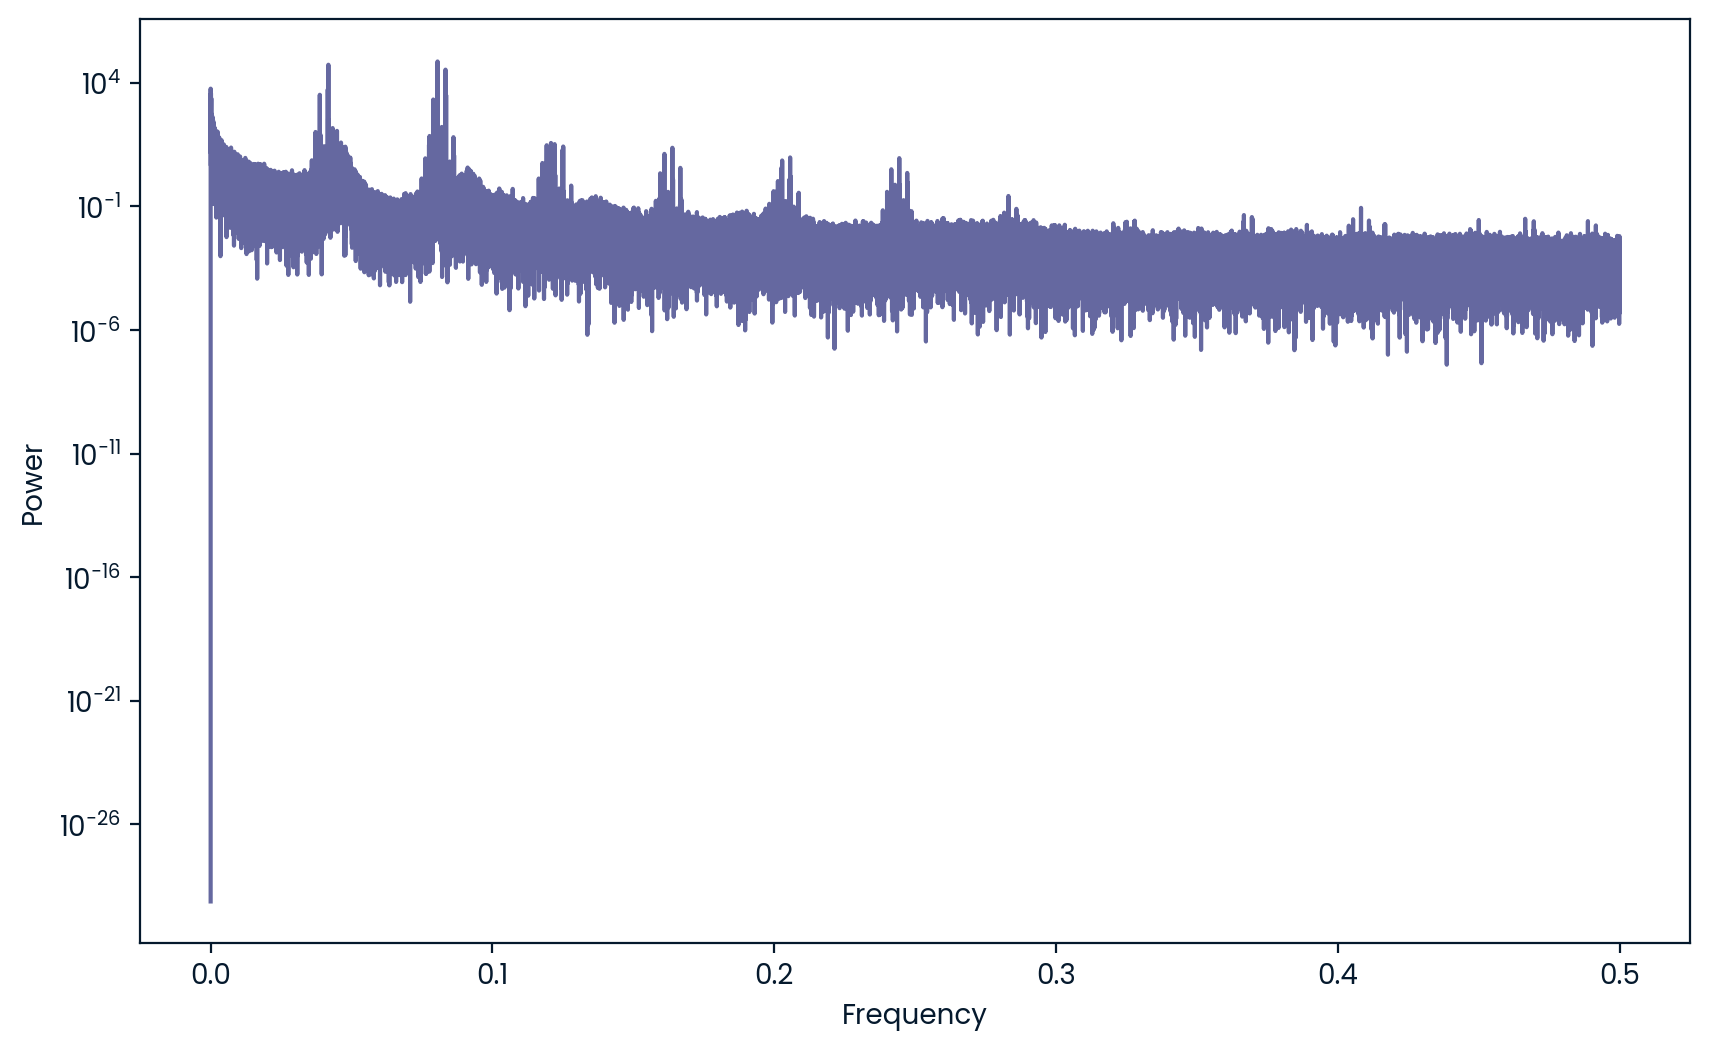

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram

# Extract the standardized level data
level_standardized = df['level_standardized'].to_numpy()

# Compute the power spectrum
frequencies, power = periodogram(level_standardized)

# Plot the power spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.yscale('log')
# plt.show()

Peaks in the power spectrum will be determined using `scipy.signal`'s `find_peaks`.

In [9]:


# Find peaks in the power spectrum
peaks, _ = find_peaks(power, height=0)

# Extract the frequencies corresponding to the peaks
dominant_frequencies = frequencies[peaks].tolist()

In [10]:
from scipy.signal import find_peaks

# Find peaks in the power spectrum
peaks, properties = find_peaks(power, height=0)

# Extract the frequencies and corresponding power values for the peaks
peak_frequencies = frequencies[peaks]
peak_powers = properties['peak_heights']

# Create a list of tuples (frequency, power) and sort by power in descending order
sorted_peaks = sorted(zip(peak_frequencies, peak_powers), key=lambda x: x[1], reverse=True)

# Extract the sorted frequencies
sorted_frequencies = [freq for freq, _ in sorted_peaks]

# Convert the sorted frequencies to their original time resolution then divide by 24 to get the 'daily' resolution

original_time_resolution = (1./24) / np.array(sorted_frequencies)

In [11]:
np.round(original_time_resolution,2)[:3]

array([0.52, 1.  , 0.5 ])

The result reveals that there is a predominant half-day (12-hour; based on the `original_time_resolution`'s top value of 0.52) seasonality in the water levels in Venezia.

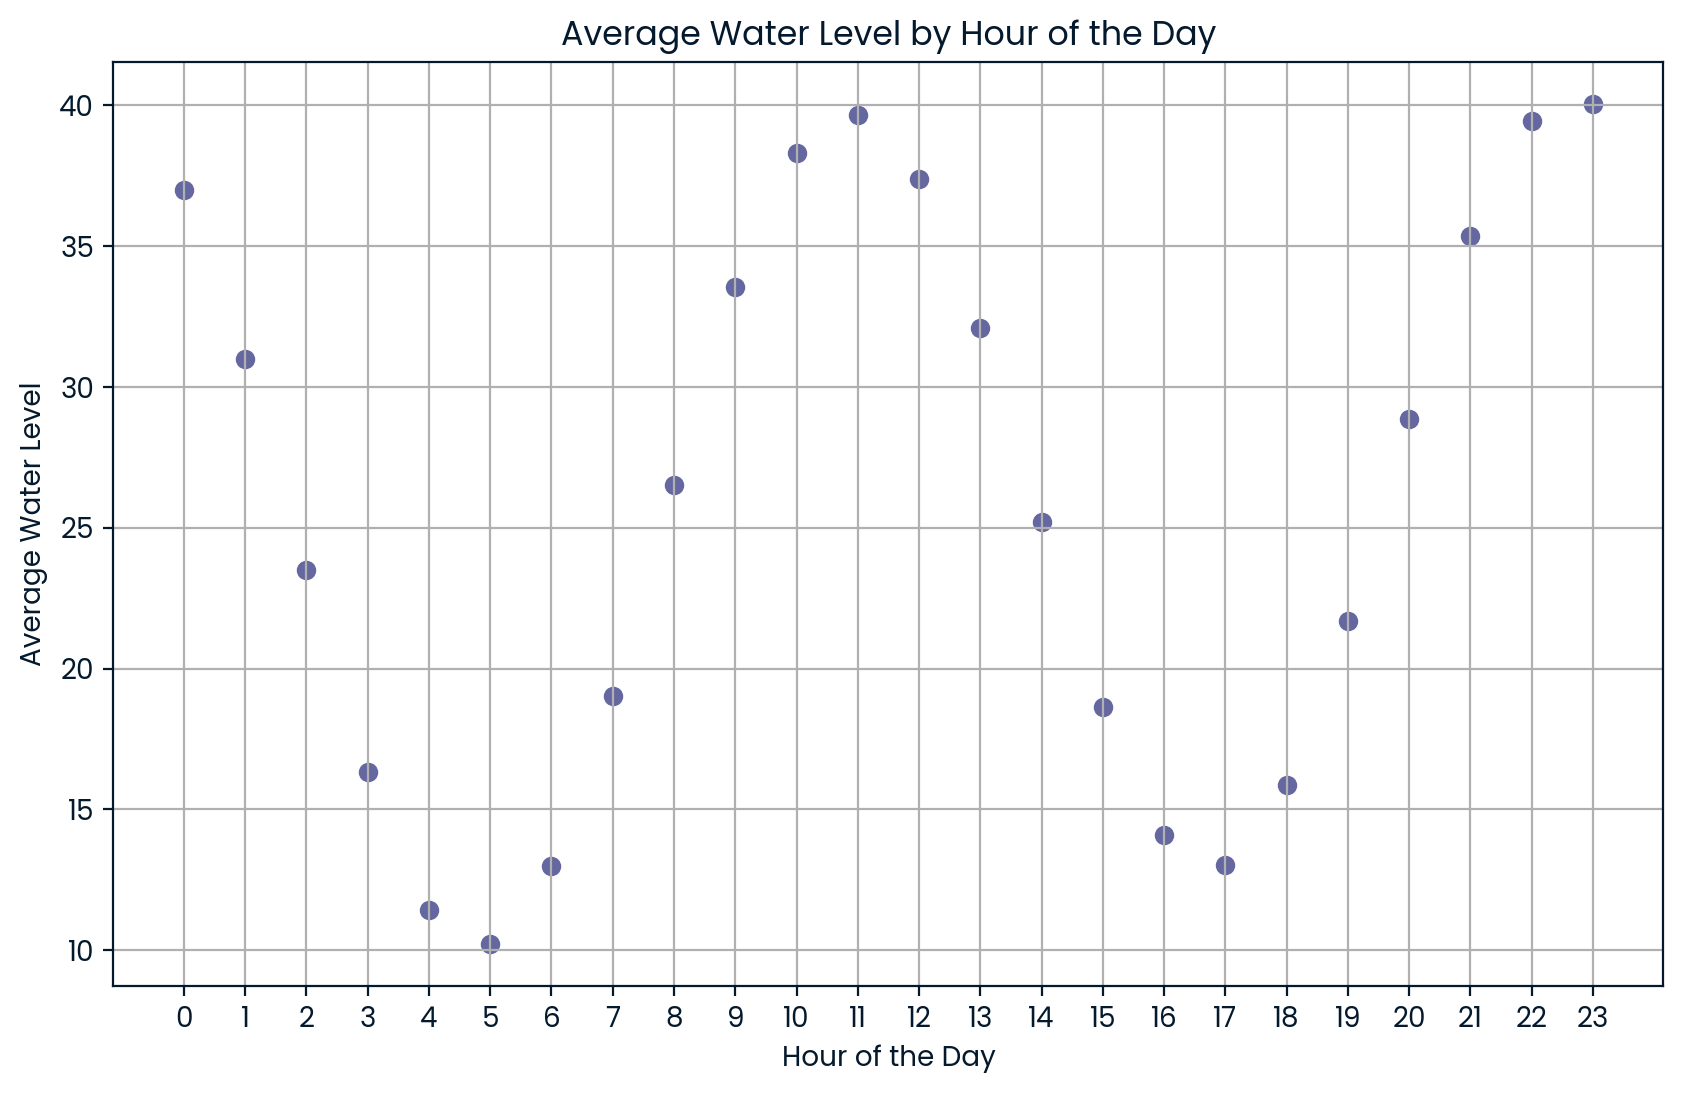

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

# Create a new column for the hour of the day
df = df.with_columns([pl.col('datetime').dt.hour().alias('hour')])

# Group by hour and calculate the mean level for each hour
hourly_avg = df.groupby('hour').agg(pl.col('level').mean().alias('avg_level'))

# Plot the hourly average levels to highlight 12-hour seasonality
plt.figure(figsize=(10, 6))
plt.scatter(hourly_avg['hour'], hourly_avg['avg_level'])#, marker='o')
plt.title('Average Water Level by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Water Level')
plt.xticks(range(0, 24, 1))
plt.grid(True)

Given this seasonality, sine and cosine transformations for `level` were also computed.

In [13]:
# Given the 12-hour periodicity for the water level, calculate the sine and cosine transformations
df = df.with_columns([
    (pl.col('level') * (2 * np.pi / 12)).sin().alias('sin_12h'),
    (pl.col('level') * (2 * np.pi / 12)).cos().alias('cos_12h')
])


df.head()

datetime,level,level_standardized,hour,sin_12h,cos_12h
datetime[μs],f64,f64,i8,f64,f64
1983-01-01 01:00:00,44.0,0.621919,1,-0.866025,-0.5
1983-01-01 02:00:00,35.0,0.31296,2,-0.5,0.866025
1983-01-01 03:00:00,23.0,-0.098985,3,-0.5,0.866025
1983-01-01 04:00:00,10.0,-0.545259,4,-0.866025,0.5
1983-01-01 05:00:00,1.0,-0.854218,5,0.5,0.866025


I then calculated the ACF of the standardized `level` using `statsmodels`.

In [14]:
from statsmodels.tsa.stattools import acf

# Calculate the ACF of the standardized level
acf_values = acf(df['level_standardized'], nlags=24)

# Find the peaks in the ACF values
peaks, _ = find_peaks(acf_values)

# Get the top 5 dominant peaks
top_5_peaks = sorted(peaks, key=lambda x: acf_values[x], reverse=True)[:5]

# Print the top 5 dominant peaks
top_5_peaks

[12]

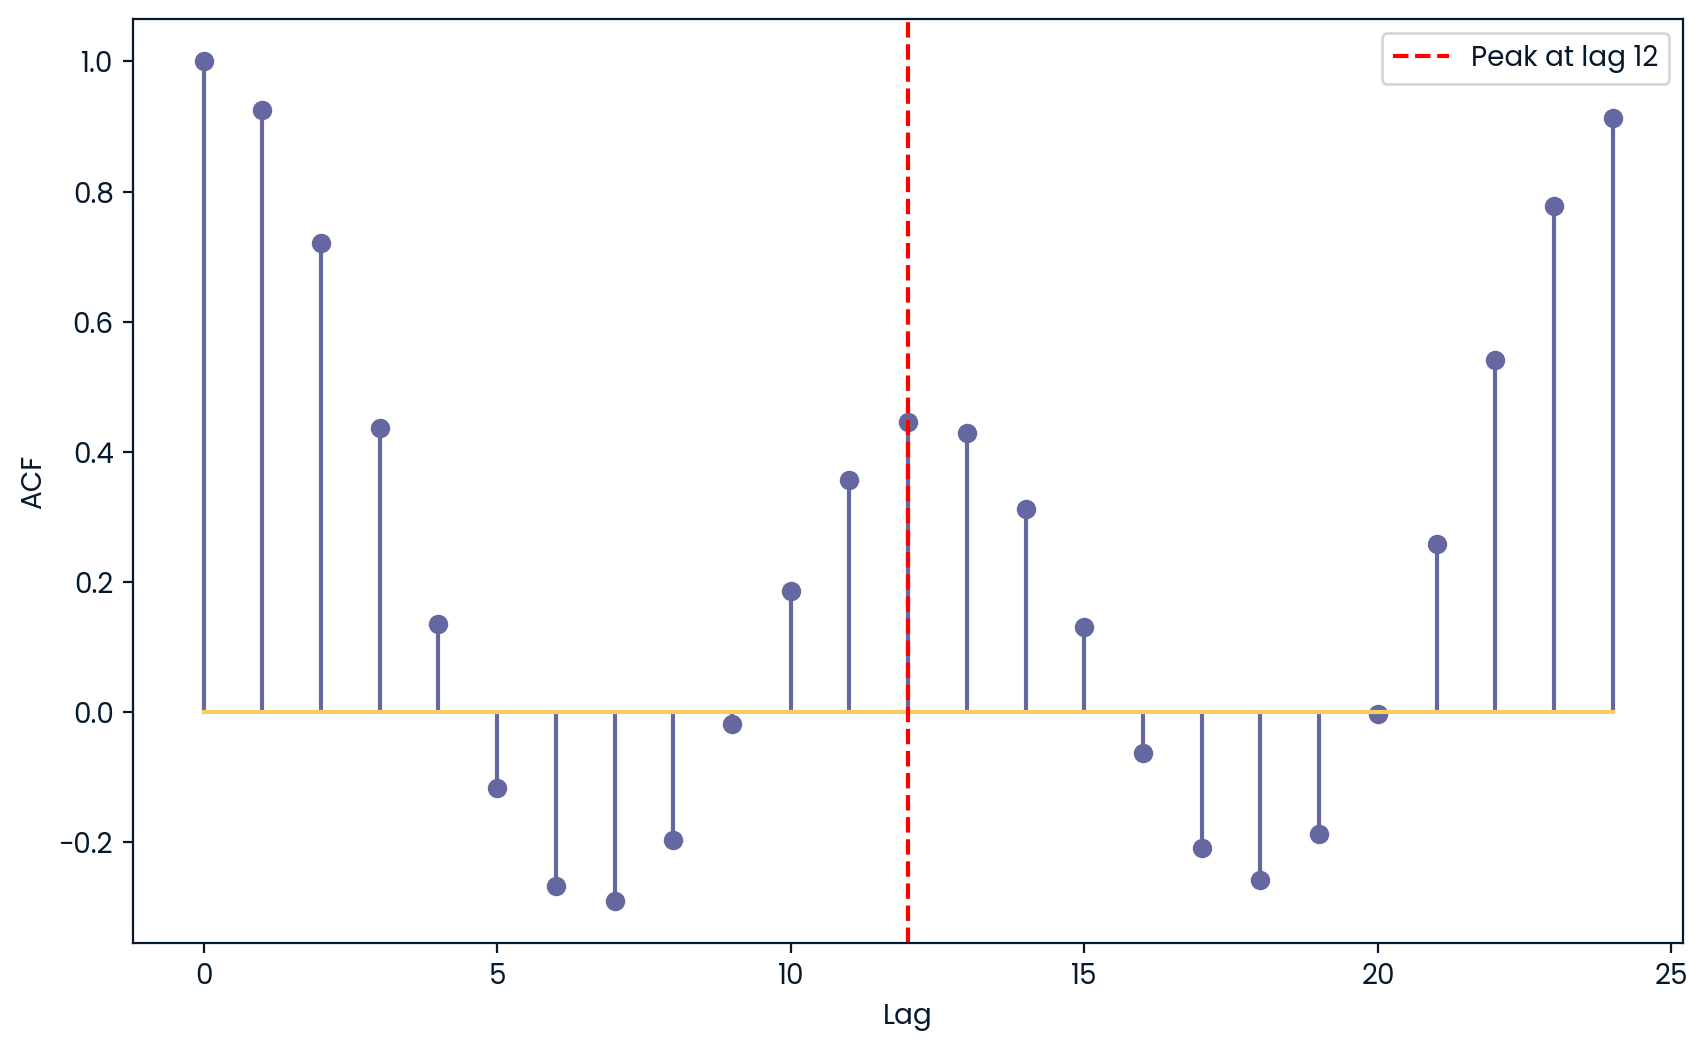

In [15]:
# Plot the ACF values
plt.figure(figsize=(10, 6))
plt.stem(range(len(acf_values)), acf_values)
plt.xlabel('Lag')
plt.ylabel('ACF')

# Highlight the top peaks with vertical lines
for peak in top_5_peaks:
    plt.axvline(x=peak, color='r', linestyle='--', label=f'Peak at lag {peak}')


plt.legend()

The plot above shows that the optimal lag for `level_standardized` (the standardized versio n of `level`) is at lag 12 h. 



Given these results, I propose to construct a LightGBM-based forecaster of water levels in Venezia using lagged values of the sine- and cosine-transformed versions at 1 h to 12 h ago as well as the hour of day to predict the water level 24 h after. Prior to building the model, hyperparameters will be optimized using Bayesian optimization. Following the train-test splits, the optimized model will be trained on the training data. Finally, the model will undergo testing and calculate the RMSE based on the predicted and actual values of the test set.

In [64]:
!pip install scikit-optimize bayesian-optimization

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [94]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer


# Create lagged features
for lag in range(1, 13):
    df = df.with_columns([
        pl.col('sin_12h').shift(lag).alias(f'sin_12h_lag_{lag}'),
        pl.col('cos_12h').shift(lag).alias(f'cos_12h_lag_{lag}')
    ])

# Drop rows with NaN values due to lagging
df = df.drop_nulls()

# Define features and target
features = [f'sin_12h_lag_{lag}' for lag in range(1, 13)] + \
           [f'cos_12h_lag_{lag}' for lag in range(1, 13)] + ['hour']
target = 'level_standardized'

# Split data into training and test sets
X = df.select(features).to_numpy()
y = df.select(target).to_numpy().ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LightGBM model
model = lgb.LGBMRegressor()

# Define the parameter search space
param_space = {
    'num_leaves': Integer(20, 50),
    'max_depth': Integer(5, 15),
    'learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'n_estimators': Integer(100, 1000)
}

# Perform Bayesian optimization
opt = BayesSearchCV(model, param_space, n_iter=1, cv=3, random_state=42, n_jobs=-1)
opt.fit(X_train, y_train)

# Train the best model
best_model = opt.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# # Assuming StandardScaler was used for standardization
# scaler = StandardScaler()
# scaler.fit(df.select('level_standardized').to_numpy().reshape(-1, 1))

# Convert predictions back to original scale
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()


# Calculate model accuracy
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse_original = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)).ravel(), y_pred_original)
r2_original = r2_score(scaler.inverse_transform(y_test.reshape(-1, 1)).ravel(), y_pred_original)

mse, r2, mse_original, r2_original

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2424
[LightGBM] [Info] Number of data points in the train set: 154221, number of used features: 25
[LightGBM] [Info] Start training from score -0.001291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2396
[LightGBM] [Info] Number of data points in the train set: 154221, number of used features: 25
[LightGBM] [Info] Start training from score 0.001435
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2417
[LightGBM] [Info] Number of data points in the train 

(0.04752921016404925, 0.952838827358794, 40.33146735900433, 0.952838827358794)

In [98]:
# Convert predictions back to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

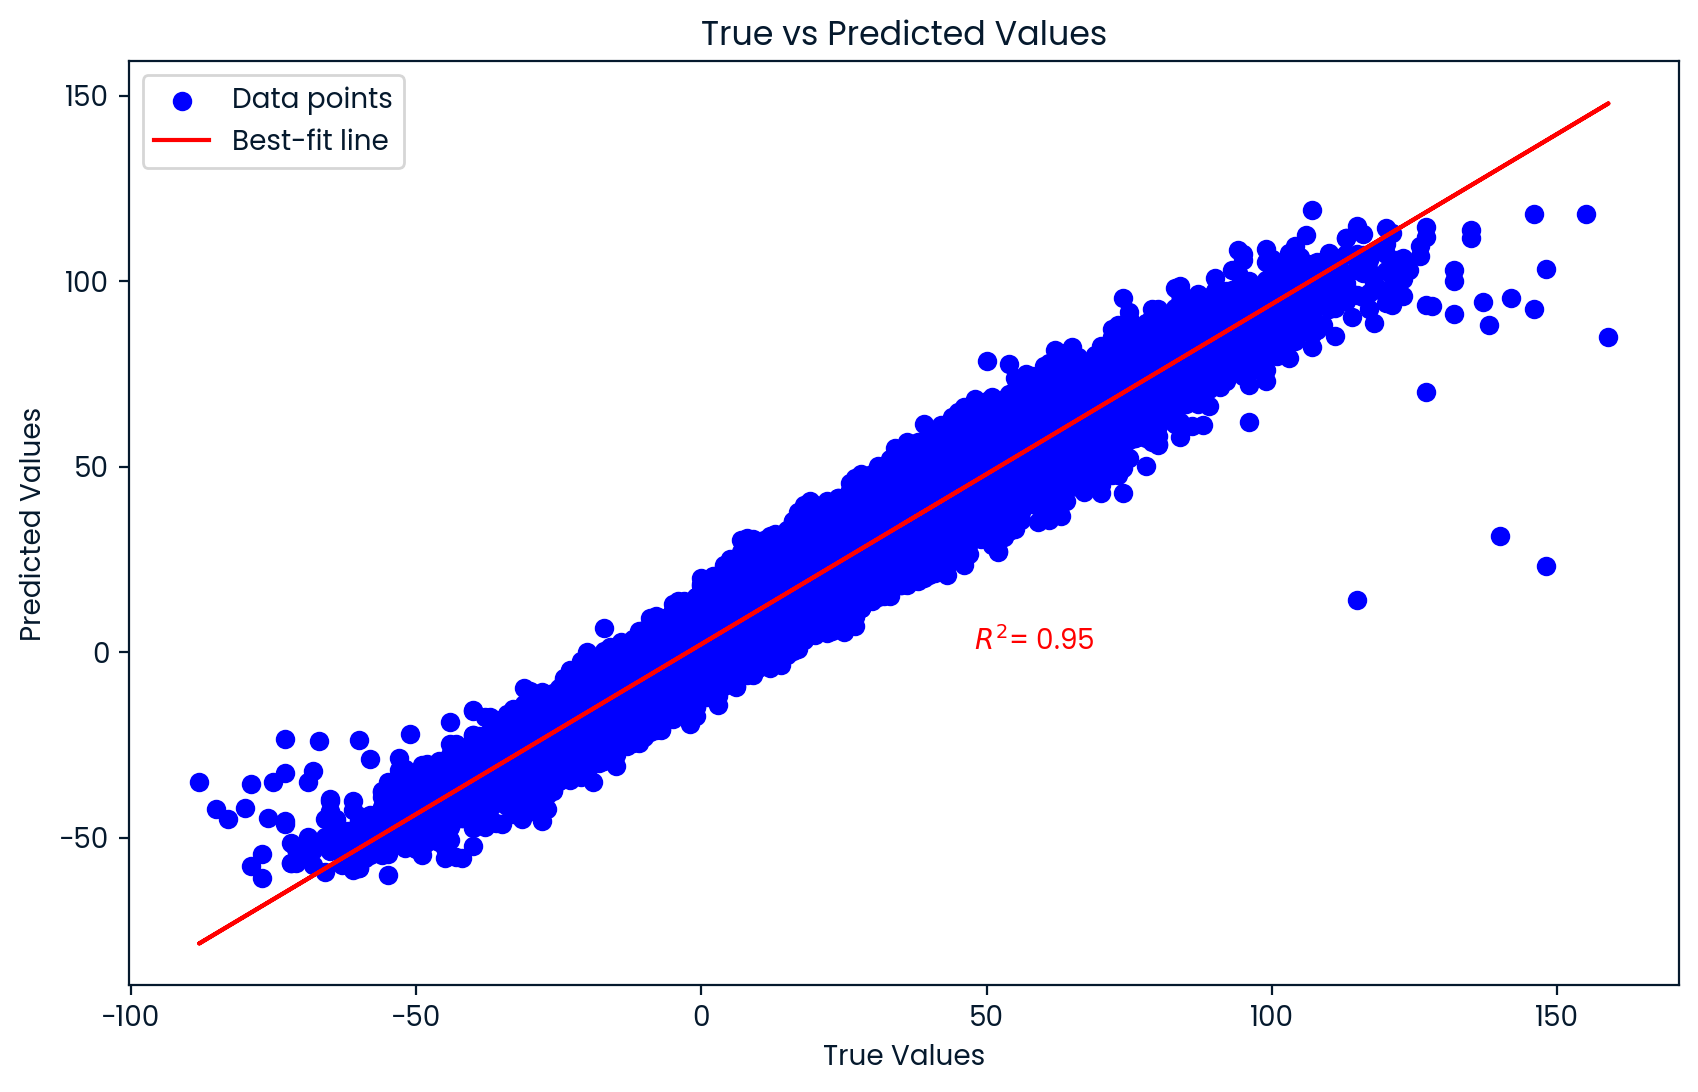

In [104]:
from sklearn.metrics import r2_score

# Calculate the best-fit line
slope, intercept = np.polyfit(y_test_original, y_pred_original, 1)
best_fit_line = slope * y_test_original + intercept

# Calculate R2 score
r2 = r2_score(y_test_original, y_pred_original)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, color='blue', label='Data points')
plt.plot(y_test_original, best_fit_line, color='red', label='Best-fit line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')

# Positioning the R2 text just below the best-fit line
x_text = np.min(y_test_original) + (np.max(y_test_original) - np.min(y_test_original)) * 0.55
y_text = np.min(best_fit_line) + (np.max(best_fit_line) - np.min(best_fit_line)) * 0.35
plt.text(x_text, y_text, f'$R^{2}$= {r2:.2f}', color='red')

plt.legend()

In this notebook, I provided a succint workflow to develop a machine learning-based forecaster of water levels in Venezia, Italia. Other avenues to explore involve including climatological variables like rainfall and temperatures as well as considering other machine learning models like LSTM. If you have questions, send them over at jprmaulion[at]gmail[dot]com.